*Author: C Mitchell*

This notebook is a condensed / summarized version of the partial least squares analysis for estimating biomass (wet weight) of fucus and asco

# Initialization

Importing the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import warnings

%matplotlib inline

In [2]:
sldf = pd.read_csv('../data/spectral_library.csv')
metadf = pd.read_csv('../data/sample_list_v3.csv')

Extracting only the data with a wavelength of less than 1800 nm

In [3]:
sldf = sldf.loc[sldf.Wvl <= 1800]

## Defining functions

In [4]:
def datawrangle(sldf,metadf,regex,target):
    '''create x and y variables for PLS where
    sldf = spectral library dataframe with all data
    metadf = metadata dataframe
    regex = regex as a string for which columns to filter on
    e.g. "ucus\d*\w*_mean"
    target = column name from metadf that is being predicted e.g. wet_weight'''
    
    meandf = sldf.filter(regex = regex)
    meandf = meandf.rename(columns=lambda x: re.sub('_mean','',x))
    
    X1 = meandf.dropna().T
    X1.index.name = 'idkey'
    y1 = metadf
    combineddf = X1.merge(y1,on='idkey')
    
    y = combineddf[target].values
    X = combineddf.filter(regex = '[0-9]').values
    
    return X,y

In [5]:
def plscalc(X,y):
    warnings.filterwarnings('ignore')
    
    #define cross-validation method
    cv = model_selection.LeaveOneOut()

    #making pipeline
    mses = []
    for n_comps in np.arange(1,40):
        pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=n_comps))
        score = -1*model_selection.cross_val_score(pls, X, y, cv=cv, scoring = 'neg_mean_squared_error')
        val = score.mean()
        mses += [val]     

    #finding number of components
    idx = np.argmin(mses)

    # predictions
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

    #pls
    pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=idx+1))
    pls.fit(X_train, y_train)
    
    return X_train,X_test,y_train,y_test,pls

In [6]:
def plsstats(pls,X,y):
    performancestats = {'rmse' : np.sqrt(mean_squared_error(y, pls.predict(X))),
    'mae' : mean_absolute_error(y, pls.predict(X)),
    'r2' : pls.score(X,y)}
    
    return performancestats

In [7]:
def plsplot(pls,X,y):
    plt.plot(y, pls.predict(X),'.')
    plt.plot(y,y,'-',label = 'expected')
    z = np.polyfit(y, pls.predict(X),1)
    plt.plot(y,np.polyval(z,y),'-',label='predicted')
    plt.xlabel('lab measured biomass (g)')
    plt.ylabel('predicted biomass from hyperspectral reflectance (g)')
    plt.legend()

# PLS Analysis

In the following sections, I create a model for biomass from reflectance for both asco and fucus combined, for asco only and for fucus only. In each case, I split the dataset 70% for training, 30% of testing.

For each model there's two graphs plotted:
1. The test results
2. The training dataset

The performance of all the models is given after all the graphs (in the Stats Summary subsection).


## Asco + Fucus combined

In [29]:
X,y = datawrangle(sldf,metadf,'_mean','wet_weight_sensed')
X_train,X_test,y_train,y_test,pls = plscalc(X,y)
performancestats_both = plsstats(pls,X_test,y_test)

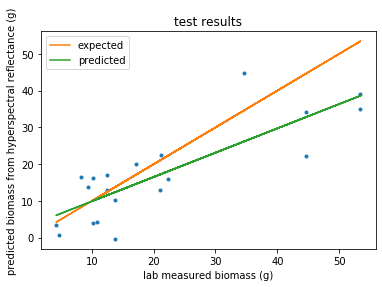

In [30]:
plsplot(pls,X_test,y_test)
plt.title('test results');

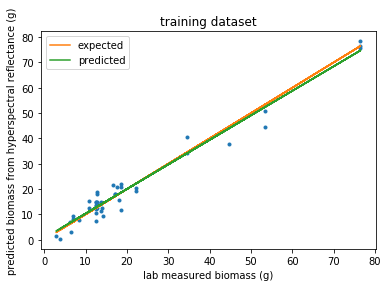

In [31]:
plsplot(pls,X_train,y_train)
plt.title('training dataset');

## Asco

In [32]:
X,y = datawrangle(sldf,metadf,'sco\d*\w*_mean','wet_weight_sensed')
X_train,X_test,y_train,y_test,pls = plscalc(X,y)
performancestats_asco = plsstats(pls,X_test,y_test)

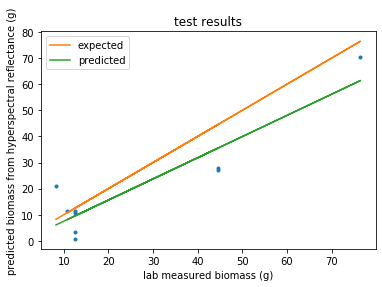

In [33]:
plsplot(pls,X_test,y_test)
plt.title('test results');

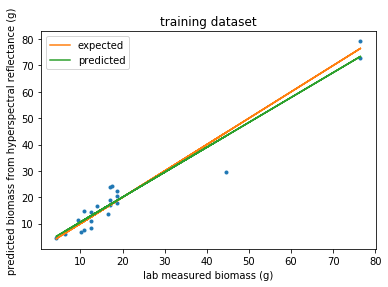

In [34]:
plsplot(pls,X_train,y_train)
plt.title('training dataset');

## Fucus

In [35]:
X,y = datawrangle(sldf,metadf,'ucus\d*\w*_mean','wet_weight_sensed')
X_train,X_test,y_train,y_test,pls = plscalc(X,y)
performancestats_fucus = plsstats(pls,X_test,y_test)

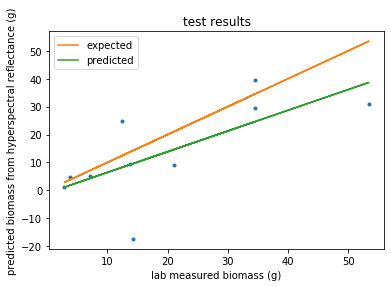

In [36]:
plsplot(pls,X_test,y_test)
plt.title('test results');

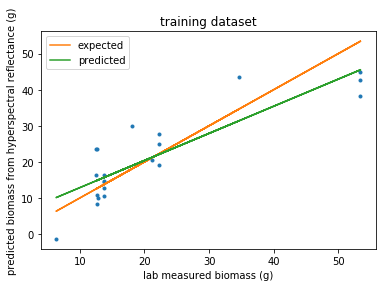

In [37]:
plsplot(pls,X_train,y_train)
plt.title('training dataset');

## Stats summary

In [38]:
pd.DataFrame({'both' : performancestats_both,
              'asco' : performancestats_asco,
              'fucus' : performancestats_fucus}).T

,rmse,mae,r2
both,9.598975,7.678721,0.620473
asco,10.569500,8.549905,0.777888
fucus,13.710556,9.721178,0.215583
